In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [211]:
from datetime import datetime as dt

import tensorflow as tf
from tensorflow import keras

from module import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data
- 해당의 데이터는 movielens 데이터이며, train_test_split 으로 나누어져 훈련용, 시험용 데이터로 나누어진다.
- generate_trainset, generate_testset 으로 인해 반환되는 값은 numpy array의 형식으로 X, y 로 반환된다.

In [212]:
loader = DataLoader()

X_train, y_train = loader.generate_trainset()
X_test, y_test = loader.generate_testset()

print("훈련 데이터 shape : {}, 훈련 라벨 갯수 : {}".format(X_train.shape, y_train.size))
print("테스트 데이터 shape : {}, 테스트 라벨 갯수 : {}".format(X_test.shape, y_test.size))

훈련 데이터 shape : (80003, 2), 훈련 라벨 갯수 : 80003
테스트 데이터 shape : (19259, 2), 테스트 라벨 갯수 : 19259


# 2. Generalized MF (Matrix Factorization)

## 1. Generate GMF Model Process

In [213]:
# 1. Setting Value 
num_users = loader.num_users
num_items = loader.num_items
latent_features = 8 # 임베딩 층이 만들어낼 잠재변수의 갯수
regs = 0

In [214]:
# 2. 입력 층 생성
user_input = keras.Input(shape=(1,), dtype='int32')
item_input = keras.Input(shape=(1,), dtype='int32')

In [215]:
# 3. embedding 층 생성
user_embedding = keras.layers.Embedding(
                    num_users,
                    latent_features,
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='user_emebedding')
item_embedding = keras.layers.Embedding(
                    num_items,
                    latent_features,
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='item_emebedding')

### 1. 중간점검
- embedding 층은 입력값에 대하여 어떠한 변화를 줄 때 사용된다. 주로 자연어 처리에서 one-hot encoding 을 진행할 때 사용 하는 층이다.
- 현재의 예제에서는 유저의 인덱스를 letent_features (잠재 의미)의 갯수를 가진 잠재 벡터로 만드는 역할을 하며, 여기에 적용되는 식은 l2 정규화를 사용한다.
    - 하지만 해당 단계 까지는 latent space라고 보아도 무방하다.

In [216]:
user_model = keras.Sequential()
item_model = keras.Sequential()

user_model.add(user_input)
user_model.add(user_embedding)

item_model.add(item_input)
item_model.add(item_embedding)

user_output = user_model(X_train[:, 0])
item_output = item_model(X_train[:, 1])

print("---- 사용자 ----")
print("입력 값: {}".format(X_train[0, 0]))
print("임베딩 층 출력 값: {}".format(user_output[0].numpy()))
print("훈련 데이터 shape: {}\n".format(user_output.shape))

print("---- 아이템 ----")
print("입력 값: {}".format(X_train[0, 1]))
print("임베딩 층 출력 값: {}".format(item_output[0].numpy()))
print("훈련 데이터 shape: {}".format(item_output.shape))

---- 사용자 ----
입력 값: 0
임베딩 층 출력 값: [[-0.02051265 -0.00845256  0.04035517 -0.02870136  0.02210058  0.020598
  -0.01471566  0.00197081]]
훈련 데이터 shape: (80003, 1, 8)

---- 아이템 ----
입력 값: 0
임베딩 층 출력 값: [[ 0.00317975  0.01180904  0.04545465  0.04338073 -0.0476738  -0.00165626
   0.01343837 -0.02879767]]
훈련 데이터 shape: (80003, 1, 8)


In [217]:
# 4. Flatten 층
user_latent = keras.layers.Flatten()
item_latent = keras.layers.Flatten()

user_model.add(user_latent)
item_model.add(item_latent)

user_output = user_model(X_train[:, 0])
item_output = item_model(X_train[:, 1])

print("---- 사용자 ----")
print("입력 값: {}".format(X_train[0, 0]))
print("임베딩 층 출력 값: {}".format(user_output[0].numpy()))
print("훈련 데이터 shape: {}\n".format(user_output.shape))

print("---- 아이템 ----")
print("입력 값: {}".format(X_train[0, 1]))
print("임베딩 층 출력 값: {}".format(item_output[0].numpy()))
print("훈련 데이터 shape: {}".format(item_output.shape))

---- 사용자 ----
입력 값: 0
임베딩 층 출력 값: [-0.02051265 -0.00845256  0.04035517 -0.02870136  0.02210058  0.020598
 -0.01471566  0.00197081]
훈련 데이터 shape: (80003, 8)

---- 아이템 ----
입력 값: 0
임베딩 층 출력 값: [ 0.00317975  0.01180904  0.04545465  0.04338073 -0.0476738  -0.00165626
  0.01343837 -0.02879767]
훈련 데이터 shape: (80003, 8)


In [218]:
# 5. concat with multiply
concat = keras.layers.Multiply()
merge_output = concat([user_output, item_output])

print("---- 사용자 X 아이템 ----")
print("입력 값: {}".format(X_train[0, 0], X_train[0, 1]))
print("임베딩 층 출력 값: {}".format(merge_output[0].numpy()))
print("훈련 데이터 shape: {}\n".format(merge_output.shape))

---- 사용자 X 아이템 ----
입력 값: 0
임베딩 층 출력 값: [-6.5225140e-05 -9.9816585e-05  1.8343304e-03 -1.2450861e-03
 -1.0536186e-03 -3.4115572e-05 -1.9775449e-04 -5.6754609e-05]
훈련 데이터 shape: (80003, 8)



In [219]:
# 6. Dense Layer
output_layer = keras.layers.Dense(1, kernel_initializer=keras.initializers.lecun_uniform(), name='output')
output = output_layer(merge_output)

print("---- GMF의 결과값은 사용자와 아이템 간의 선형적 관계를 나타낸다. ----")
print(output.numpy())

---- GMF의 결과값은 사용자와 아이템 간의 선형적 관계를 나타낸다. ----
[[-8.0654339e-05]
 [-3.6534763e-04]
 [ 6.7281967e-04]
 ...
 [ 3.5630772e-05]
 [ 2.8997893e-05]
 [-2.2314362e-04]]


## 2. Use

In [220]:
# 1. model setting
from model import GMF
model = GMF(loader.num_users, loader.num_items).get_model()

In [221]:
# 2. Callbacks
early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# model_out_file = 'Pretrain/GMF_%s.h5' % (datetime.now().strftime('%Y-%m-%d-%h-%m-%s'))
# model_check_cb = keras.callbacks.ModelCheckpoint(model_out_file, save_best_only=True)

In [224]:
# 3. Compile
learner = "adam"
learning_rate = 0.001

if learner == "adagrad":
    model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate), loss='mse')
elif learner == "rmsprop":
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), loss='mse')
elif learner == "adam":
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
else:
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse')

In [225]:
# 4. Train
epochs = 10
batch_size = 32

history = model.fit(
            [X_train[:, 0], X_train[:, 1]], y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
            callbacks=[early_stop_cb]
        )

Epoch 1/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.5504 - val_loss: 0.8429
Epoch 2/10
2501/2501 [==============================] - 3s 1ms/step - loss: 0.5165 - val_loss: 0.8483
Epoch 3/10
2501/2501 [==============================] - 3s 1ms/step - loss: 0.4854 - val_loss: 0.8591
Epoch 4/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.4618 - val_loss: 0.8705
Epoch 5/10
2501/2501 [==============================] - 4s 1ms/step - loss: 0.4420 - val_loss: 0.8848
Epoch 6/10
2501/2501 [==============================] - 4s 2ms/step - loss: 0.4271 - val_loss: 0.8922
Epoch 7/10
2501/2501 [==============================] - 4s 1ms/step - loss: 0.4141 - val_loss: 0.9076
Epoch 8/10
2501/2501 [==============================] - 3s 1ms/step - loss: 0.4039 - val_loss: 0.9159
Epoch 9/10
2501/2501 [==============================] - 3s 1ms/step - loss: 0.3951 - val_loss: 0.9311
Epoch 10/10
2501/2501 [==============================] - 4s 1ms/step - loss: 0.387

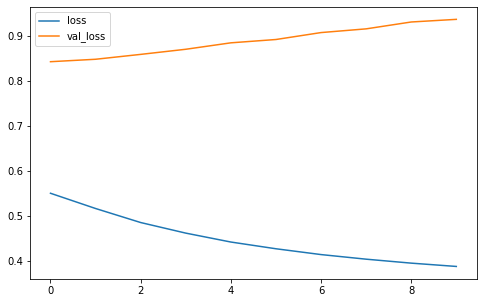

[3.7625666 2.5908964 3.591821  3.4018238 4.5492563 4.5212317 4.2892637
 2.09861   4.1042223 2.1768792]
[5. 3. 4. 4. 5. 5. 5. 3. 4. 2.]


In [226]:
# 5. Result
pd.DataFrame(history.history).plot(figsize= (8,5))
plt.show()
test_sample = X_test[:10]
test_sample_label = y_test[:10]
print(model.predict([test_sample[:, 0], test_sample[:, 1]]).flatten())
print(test_sample_label)